# Model Evaluation - Legal Clause Detection

This notebook provides comprehensive evaluation of the BERT-based legal clause detection model, including multi-label classification metrics, per-clause analysis, and clean clause name integration.


Using device: cpu
=== Model and Data Loaded ===
Model: bert-base-uncased
Number of clause types: 41
Test samples: 1741
Legal model evaluator created!
Generating predictions on test set...
Processed 160/1741 samples...
Processed 320/1741 samples...
Processed 480/1741 samples...
Processed 640/1741 samples...
Processed 800/1741 samples...
Processed 960/1741 samples...
Processed 1120/1741 samples...
Processed 1280/1741 samples...
Processed 1440/1741 samples...
Processed 1600/1741 samples...
Generated predictions for 1741 samples
Prediction shape: (1741, 41)
Ground truth shape: (1741, 41)
Total positive labels: 0.0
Evaluating multi-label classification performance...

=== THRESHOLD 0.1 ===
Hamming Loss: 0.0162
Jaccard Score: 0.0000
F1 (Micro): 0.0000
F1 (Macro): 0.0000
F1 (Weighted): 0.0000
Precision (Micro): 0.0000
Recall (Micro): 0.0000

=== THRESHOLD 0.3 ===
Hamming Loss: 0.0100
Jaccard Score: 0.0000
F1 (Micro): 0.0000
F1 (Macro): 0.0000
F1 (Weighted): 0.0000
Precision (Micro): 0.0000
Re

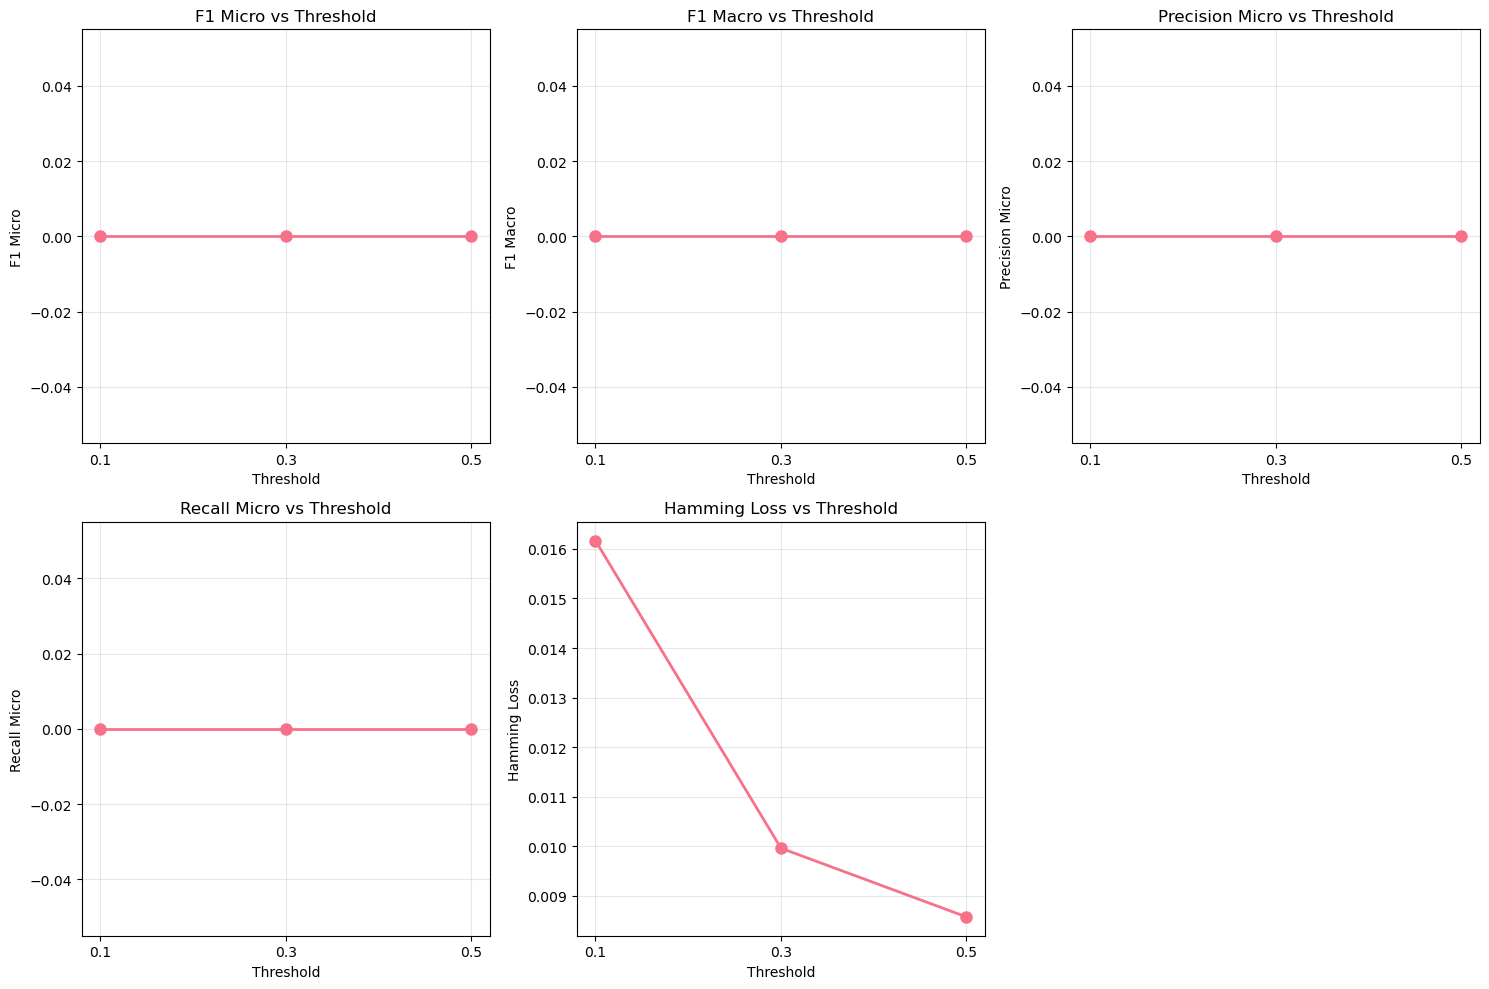

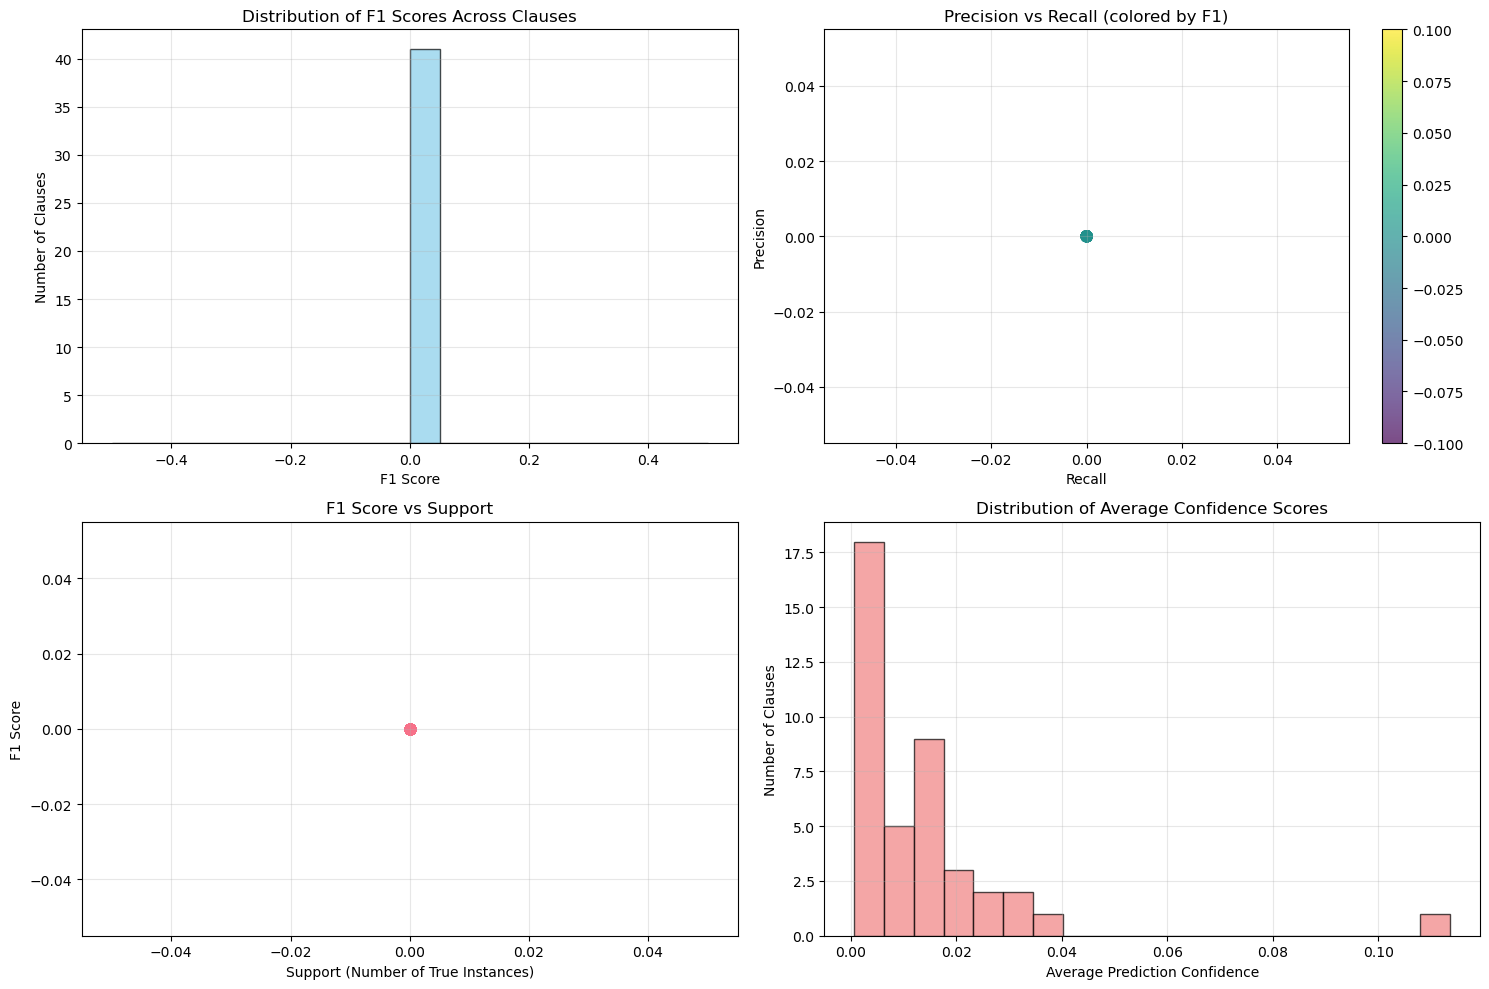


=== MODEL PERFORMANCE COMPARISON ===
------------------------------------------------------------
           Metric  Training   Test  Difference
       F1 (Micro)    0.7867 0.0000     -0.7867
       F1 (Macro)    0.4905 0.0000     -0.4905
Precision (Micro)    0.8922 0.0000     -0.8922
   Recall (Micro)    0.7036 0.0000     -0.7036
     Hamming Loss    0.0041 0.0100      0.0058
COMPREHENSIVE MODEL EVALUATION REPORT
LEGAL CLAUSE DETECTION - BERT MULTI-LABEL CLASSIFICATION

MODEL OVERVIEW
----------------------------------------
  • Architecture: Multi-label BERT
  • Number of clause types: 41
  • Test samples evaluated: 1741
  • Device used: cpu

BEST PERFORMANCE (Threshold: 0.1)
----------------------------------------
  • F1 Score (Micro): 0.0000
  • F1 Score (Macro): 0.0000
  • Precision (Micro): 0.0000
  • Recall (Micro): 0.0000
  • Hamming Loss: 0.0162
  • Jaccard Score: 0.0000

CLAUSE TYPE ANALYSIS
----------------------------------------
  Top 5 Performing Clauses:
    • Affiliat

In [1]:
# Setup and Imports

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    precision_score, recall_score, f1_score, 
    accuracy_score, hamming_loss, jaccard_score,
    classification_report, multilabel_confusion_matrix,
    precision_recall_curve, average_precision_score
)
from transformers import AutoTokenizer, AutoModel
import ast
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load Model and Data

class MultiLabelBERT(nn.Module):
    """Multi-label BERT model for legal clause classification"""
    def __init__(self, model_name, num_labels, dropout=0.3):
        super(MultiLabelBERT, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.num_labels = num_labels
        
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        return {'logits': logits, 'hidden_states': outputs.last_hidden_state}

def load_legal_model_and_data():
    """Load the trained legal BERT model and test data"""
    
    # Load metadata
    with open('../data/processed/metadata.json', 'r') as f:
        metadata = json.load(f)
    
    # Load training results
    with open('../models/bert/training_results.json', 'r') as f:
        training_results = json.load(f)
    
    # Initialize model
    MODEL_NAME = training_results['model_config']['model_name']
    num_labels = training_results['model_config']['num_labels']
    
    model = MultiLabelBERT(MODEL_NAME, num_labels)
    model.load_state_dict(torch.load('../models/bert/final_model.pt', map_location=device))
    model.to(device)
    model.eval()
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained('../models/bert/')
    
    # Load test data
    test_data = pd.read_csv('../data/processed/test_multi_label.csv')
    test_data['labels'] = test_data['labels'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])
    
    return model, tokenizer, metadata, test_data, training_results

# Load everything
model, tokenizer, metadata, test_data, training_results = load_legal_model_and_data()
clause_types = metadata['clause_types']
clean_clause_names = metadata['clean_clause_names']

print("=== Model and Data Loaded ===")
print(f"Model: {training_results['model_config']['model_name']}")
print(f"Number of clause types: {len(clause_types)}")
print(f"Test samples: {len(test_data)}")

# Model Prediction Functions

class LegalModelEvaluator:
    """Comprehensive evaluator for legal BERT model"""
    
    def __init__(self, model, tokenizer, clause_types, clean_clause_names, max_length=512):
        self.model = model
        self.tokenizer = tokenizer
        self.clause_types = clause_types
        self.clean_clause_names = clean_clause_names
        self.max_length = max_length
        self.device = next(model.parameters()).device
        
    def predict_batch(self, texts, batch_size=16):
        """Generate predictions for a batch of texts"""
        all_predictions = []
        
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            batch_predictions = []
            
            with torch.no_grad():
                for text in batch_texts:
                    # Tokenize
                    encoding = self.tokenizer(
                        text,
                        truncation=True,
                        padding='max_length',
                        max_length=self.max_length,
                        return_tensors='pt'
                    )
                    
                    input_ids = encoding['input_ids'].to(self.device)
                    attention_mask = encoding['attention_mask'].to(self.device)
                    
                    # Get predictions
                    outputs = self.model(input_ids, attention_mask)
                    probs = torch.sigmoid(outputs['logits']).cpu().numpy()
                    batch_predictions.append(probs[0])
            
            all_predictions.extend(batch_predictions)
            
            if (i // batch_size + 1) % 10 == 0:
                print(f"Processed {i + len(batch_texts)}/{len(texts)} samples...")
        
        return np.array(all_predictions)
    
    def convert_to_binary_predictions(self, probabilities, threshold=0.3):
        """Convert probabilities to binary predictions using threshold"""
        return (probabilities > threshold).astype(int)

# Create evaluator
evaluator = LegalModelEvaluator(model, tokenizer, clause_types, clean_clause_names)

print("Legal model evaluator created!")

# Generate Predictions on Test Set

print("Generating predictions on test set...")
test_texts = test_data['text'].tolist()
test_probabilities = evaluator.predict_batch(test_texts)

print(f"Generated predictions for {len(test_texts)} samples")
print(f"Prediction shape: {test_probabilities.shape}")

# Prepare Ground Truth Labels

def prepare_ground_truth_matrix(test_data, clause_types):
    """Convert string labels to binary matrix"""
    n_samples = len(test_data)
    n_labels = len(clause_types)
    
    y_true = np.zeros((n_samples, n_labels))
    
    for i, labels in enumerate(test_data['labels']):
        for label in labels:
            if label in clause_types:
                label_idx = clause_types.index(label)
                y_true[i, label_idx] = 1
    
    return y_true

y_true = prepare_ground_truth_matrix(test_data, clause_types)
print(f"Ground truth shape: {y_true.shape}")
print(f"Total positive labels: {np.sum(y_true)}")

# Multi-Label Classification Evaluation

def evaluate_multilabel_classification(y_true, y_pred_proba, thresholds=[0.1, 0.3, 0.5]):
    """Comprehensive multi-label classification evaluation"""
    
    results = {}
    
    for threshold in thresholds:
        y_pred = (y_pred_proba > threshold).astype(int)
        
        # Overall metrics
        metrics = {
            'threshold': threshold,
            'hamming_loss': hamming_loss(y_true, y_pred),
            'jaccard_score': jaccard_score(y_true, y_pred, average='micro'),
            'precision_micro': precision_score(y_true, y_pred, average='micro', zero_division=0),
            'recall_micro': recall_score(y_true, y_pred, average='micro', zero_division=0),
            'f1_micro': f1_score(y_true, y_pred, average='micro', zero_division=0),
            'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
            'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
            'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
            'precision_weighted': precision_score(y_true, y_pred, average='weighted', zero_division=0),
            'recall_weighted': recall_score(y_true, y_pred, average='weighted', zero_division=0),
            'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        }
        
        # Per-class metrics
        precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
        recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
        f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
        
        metrics['per_class'] = {
            'precision': precision_per_class,
            'recall': recall_per_class,
            'f1': f1_per_class
        }
        
        results[threshold] = metrics
    
    return results

# Evaluate with different thresholds
print("Evaluating multi-label classification performance...")
evaluation_results = evaluate_multilabel_classification(y_true, test_probabilities)

# Display results
for threshold, metrics in evaluation_results.items():
    print(f"\n=== THRESHOLD {threshold} ===")
    print(f"Hamming Loss: {metrics['hamming_loss']:.4f}")
    print(f"Jaccard Score: {metrics['jaccard_score']:.4f}")
    print(f"F1 (Micro): {metrics['f1_micro']:.4f}")
    print(f"F1 (Macro): {metrics['f1_macro']:.4f}")
    print(f"F1 (Weighted): {metrics['f1_weighted']:.4f}")
    print(f"Precision (Micro): {metrics['precision_micro']:.4f}")
    print(f"Recall (Micro): {metrics['recall_micro']:.4f}")

# Per-Clause Analysis with Clean Names

def analyze_per_clause_performance(y_true, y_pred_proba, clause_types, clean_clause_names, threshold=0.3):
    """Analyze performance for each clause type using clean names"""
    
    y_pred = (y_pred_proba > threshold).astype(int)
    
    clause_results = []
    
    for i, clause_type in enumerate(clause_types):
        clean_name = clean_clause_names.get(clause_type, clause_type.split('"')[1] if '"' in clause_type else clause_type[:30])
        
        # True positives, false positives, etc.
        y_true_class = y_true[:, i]
        y_pred_class = y_pred[:, i]
        
        tp = np.sum((y_true_class == 1) & (y_pred_class == 1))
        fp = np.sum((y_true_class == 0) & (y_pred_class == 1))
        tn = np.sum((y_true_class == 0) & (y_pred_class == 0))
        fn = np.sum((y_true_class == 1) & (y_pred_class == 0))
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        # Support (number of true instances)
        support = np.sum(y_true_class)
        
        # Average prediction confidence for this class
        avg_confidence = np.mean(y_pred_proba[:, i])
        
        clause_results.append({
            'clause_name': clean_name,
            'clause_type': clause_type,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': support,
            'avg_confidence': avg_confidence,
            'tp': tp,
            'fp': fp,
            'tn': tn,
            'fn': fn
        })
    
    return pd.DataFrame(clause_results)

# Analyze per-clause performance
clause_analysis = analyze_per_clause_performance(y_true, test_probabilities, clause_types, clean_clause_names)

# Display top performing clauses
print("\n=== TOP 10 CLAUSES BY F1 SCORE ===")
top_clauses = clause_analysis.nlargest(10, 'f1')[['clause_name', 'precision', 'recall', 'f1', 'support']]
print(top_clauses.to_string(index=False))

print("\n=== BOTTOM 10 CLAUSES BY F1 SCORE ===")
bottom_clauses = clause_analysis.nsmallest(10, 'f1')[['clause_name', 'precision', 'recall', 'f1', 'support']]
print(bottom_clauses.to_string(index=False))

# Visualization Functions

def plot_evaluation_results(evaluation_results):
    """Plot evaluation metrics across different thresholds"""
    
    thresholds = list(evaluation_results.keys())
    metrics_to_plot = ['f1_micro', 'f1_macro', 'precision_micro', 'recall_micro', 'hamming_loss']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics_to_plot):
        values = [evaluation_results[t][metric] for t in thresholds]
        
        axes[i].plot(thresholds, values, 'o-', linewidth=2, markersize=8)
        axes[i].set_xlabel('Threshold')
        axes[i].set_ylabel(metric.replace('_', ' ').title())
        axes[i].set_title(f'{metric.replace("_", " ").title()} vs Threshold')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xticks(thresholds)
    
    # Remove empty subplot
    fig.delaxes(axes[5])
    
    plt.tight_layout()
    plt.show()

def plot_clause_performance_distribution(clause_analysis):
    """Plot distribution of clause performance metrics"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # F1 Score distribution
    axes[0,0].hist(clause_analysis['f1'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_xlabel('F1 Score')
    axes[0,0].set_ylabel('Number of Clauses')
    axes[0,0].set_title('Distribution of F1 Scores Across Clauses')
    axes[0,0].grid(True, alpha=0.3)
    
    # Precision vs Recall
    scatter = axes[0,1].scatter(clause_analysis['recall'], clause_analysis['precision'], 
                              c=clause_analysis['f1'], cmap='viridis', alpha=0.7, s=60)
    axes[0,1].set_xlabel('Recall')
    axes[0,1].set_ylabel('Precision')
    axes[0,1].set_title('Precision vs Recall (colored by F1)')
    axes[0,1].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[0,1])
    
    # Support vs F1 Score
    axes[1,0].scatter(clause_analysis['support'], clause_analysis['f1'], alpha=0.7, s=60)
    axes[1,0].set_xlabel('Support (Number of True Instances)')
    axes[1,0].set_ylabel('F1 Score')
    axes[1,0].set_title('F1 Score vs Support')
    axes[1,0].grid(True, alpha=0.3)
    
    # Average Confidence distribution
    axes[1,1].hist(clause_analysis['avg_confidence'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1,1].set_xlabel('Average Prediction Confidence')
    axes[1,1].set_ylabel('Number of Clauses')
    axes[1,1].set_title('Distribution of Average Confidence Scores')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Generate visualizations
print("\n=== GENERATING EVALUATION VISUALIZATIONS ===")
plot_evaluation_results(evaluation_results)
plot_clause_performance_distribution(clause_analysis)

# Model Comparison with Training Results

def compare_with_training_results(evaluation_results, training_results):
    """Compare test results with training validation results"""
    
    print("\n=== MODEL PERFORMANCE COMPARISON ===")
    print("-" * 60)
    
    # Get final validation metrics from training
    final_val_metrics = training_results['test_metrics']  # This should be your final test metrics
    
    # Get best test threshold results
    best_threshold = 0.3  # You can optimize this
    test_metrics = evaluation_results[best_threshold]
    
    comparison = {
        'Metric': ['F1 (Micro)', 'F1 (Macro)', 'Precision (Micro)', 'Recall (Micro)', 'Hamming Loss'],
        'Training': [
            final_val_metrics.get('f1_micro', 0),
            final_val_metrics.get('f1_macro', 0),
            final_val_metrics.get('precision_micro', 0),
            final_val_metrics.get('recall_micro', 0),
            final_val_metrics.get('hamming_loss', 0)
        ],
        'Test': [
            test_metrics['f1_micro'],
            test_metrics['f1_macro'],
            test_metrics['precision_micro'],
            test_metrics['recall_micro'],
            test_metrics['hamming_loss']
        ]
    }
    
    comparison_df = pd.DataFrame(comparison)
    comparison_df['Difference'] = comparison_df['Test'] - comparison_df['Training']
    
    print(comparison_df.to_string(index=False, float_format='%.4f'))
    
    return comparison_df

# Compare with training results
comparison_results = compare_with_training_results(evaluation_results, training_results)

# Generate Comprehensive Report

def generate_evaluation_report(evaluation_results, clause_analysis, comparison_results):
    """Generate comprehensive evaluation report"""
    
    report = []
    report.append("="*80)
    report.append("COMPREHENSIVE MODEL EVALUATION REPORT")
    report.append("LEGAL CLAUSE DETECTION - BERT MULTI-LABEL CLASSIFICATION")
    report.append("="*80)
    
    # Model Overview
    report.append(f"\nMODEL OVERVIEW")
    report.append("-" * 40)
    report.append(f"  • Architecture: Multi-label BERT")
    report.append(f"  • Number of clause types: {len(clause_types)}")
    report.append(f"  • Test samples evaluated: {len(test_data)}")
    report.append(f"  • Device used: {device}")
    
    # Best Performance Summary
    best_threshold = max(evaluation_results.keys(), key=lambda x: evaluation_results[x]['f1_micro'])
    best_metrics = evaluation_results[best_threshold]
    
    report.append(f"\nBEST PERFORMANCE (Threshold: {best_threshold})")
    report.append("-" * 40)
    report.append(f"  • F1 Score (Micro): {best_metrics['f1_micro']:.4f}")
    report.append(f"  • F1 Score (Macro): {best_metrics['f1_macro']:.4f}")
    report.append(f"  • Precision (Micro): {best_metrics['precision_micro']:.4f}")  
    report.append(f"  • Recall (Micro): {best_metrics['recall_micro']:.4f}")
    report.append(f"  • Hamming Loss: {best_metrics['hamming_loss']:.4f}")
    report.append(f"  • Jaccard Score: {best_metrics['jaccard_score']:.4f}")
    
    # Clause Type Analysis
    report.append(f"\nCLAUSE TYPE ANALYSIS")
    report.append("-" * 40)
    
    # Top performing clauses
    top_5 = clause_analysis.nlargest(5, 'f1')
    report.append(f"  Top 5 Performing Clauses:")
    for _, row in top_5.iterrows():
        report.append(f"    • {row['clause_name']}: F1={row['f1']:.3f}, Support={row['support']}")
    
    # Challenging clauses
    bottom_5 = clause_analysis.nsmallest(5, 'f1')
    report.append(f"\n  Most Challenging Clauses:")
    for _, row in bottom_5.iterrows():
        report.append(f"    • {row['clause_name']}: F1={row['f1']:.3f}, Support={row['support']}")
    
    # Distribution Analysis
    report.append(f"\nPERFORMANCE DISTRIBUTION")
    report.append("-" * 40)
    report.append(f"  • Mean F1 Score: {clause_analysis['f1'].mean():.4f}")
    report.append(f"  • Median F1 Score: {clause_analysis['f1'].median():.4f}")
    report.append(f"  • Std F1 Score: {clause_analysis['f1'].std():.4f}")
    report.append(f"  • Clauses with F1 > 0.5: {sum(clause_analysis['f1'] > 0.5)}")
    report.append(f"  • Clauses with F1 > 0.7: {sum(clause_analysis['f1'] > 0.7)}")
    
    # Recommendations
    report.append(f"\nRECOMMENDATIONS")
    report.append("-" * 40)
    report.append(f"  • Optimal threshold for deployment: {best_threshold}")
    
    if best_metrics['f1_micro'] > 0.6:
        report.append(f"  • Model shows good performance for legal clause detection")
    elif best_metrics['f1_micro'] > 0.4:
        report.append(f"  • Model shows moderate performance, consider fine-tuning")
    else:
        report.append(f"  • Model needs significant improvement before deployment")
    
    low_support_clauses = clause_analysis[clause_analysis['support'] < 10]
    if len(low_support_clauses) > 0:
        report.append(f"  • {len(low_support_clauses)} clauses have low support (<10 examples)")
        report.append(f"  • Consider collecting more data for underrepresented clauses")
    
    report.append(f"\nEVALUATION COMPLETE")
    report.append("="*80)
    
    return '\n'.join(report)

# Generate and display report
evaluation_report = generate_evaluation_report(evaluation_results, clause_analysis, comparison_results)
print(evaluation_report)

# Save Results

# Save detailed results
clause_analysis.to_csv('../models/clause_performance_analysis.csv', index=False)
print("\nClause performance analysis saved to '../models/clause_performance_analysis.csv'")

# Save evaluation report
with open('../models/evaluation_report.txt', 'w', encoding='utf-8') as f:
    f.write(evaluation_report)
print("Evaluation report saved to '../models/evaluation_report.txt'")

print("\nCOMPREHENSIVE EVALUATION COMPLETE!")
print("All results and visualizations have been generated and saved.")

In [2]:
#### Legal Document Summarization Evaluation (Optional)

# Additional imports for text generation evaluation
try:
    from rouge import Rouge
    from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
    import nltk
    nltk.download('punkt', quiet=True)
    SUMMARIZATION_AVAILABLE = True
except ImportError:
    print("ROUGE/BLEU libraries not available. Install with: pip install rouge-score nltk")
    SUMMARIZATION_AVAILABLE = False

def evaluate_legal_summarization(predictions, references):
    """
    Evaluate legal document summarization using ROUGE and BLEU scores
    
    Args:
        predictions: List of generated summaries
        references: List of reference summaries
    
    Returns:
        Dictionary with ROUGE and BLEU scores
    """
    if not SUMMARIZATION_AVAILABLE:
        return {"error": "ROUGE/BLEU libraries not installed"}
    
    # ROUGE evaluation
    rouge = Rouge()
    rouge_scores = rouge.get_scores(predictions, references, avg=True)
    
    # BLEU evaluation
    # Convert to format expected by corpus_bleu
    references_tokenized = [[ref.split()] for ref in references]
    predictions_tokenized = [pred.split() for pred in predictions]
    
    bleu_scores = {
        'bleu_1': corpus_bleu(references_tokenized, predictions_tokenized, weights=(1, 0, 0, 0)),
        'bleu_2': corpus_bleu(references_tokenized, predictions_tokenized, weights=(0.5, 0.5, 0, 0)),
        'bleu_3': corpus_bleu(references_tokenized, predictions_tokenized, weights=(0.33, 0.33, 0.33, 0)),
        'bleu_4': corpus_bleu(references_tokenized, predictions_tokenized, weights=(0.25, 0.25, 0.25, 0.25))
    }
    
    return {
        'rouge': rouge_scores,
        'bleu': bleu_scores
    }

def evaluate_clause_extraction_as_summarization(y_true, y_pred_proba, clause_types, clean_clause_names, threshold=0.3):
    """
    Evaluate clause extraction by treating extracted clauses as 'summaries' of legal documents
    This provides a different perspective on model performance
    """
    
    y_pred = (y_pred_proba > threshold).astype(int)
    
    # Convert predictions to text summaries
    prediction_summaries = []
    reference_summaries = []
    
    for i in range(len(y_true)):
        # Get predicted clauses
        predicted_indices = np.where(y_pred[i] == 1)[0]
        predicted_clauses = [clean_clause_names.get(clause_types[idx], clause_types[idx]) for idx in predicted_indices]
        pred_summary = "; ".join(predicted_clauses) if predicted_clauses else "No clauses detected"
        
        # Get true clauses  
        true_indices = np.where(y_true[i] == 1)[0]
        true_clauses = [clean_clause_names.get(clause_types[idx], clause_types[idx]) for idx in true_indices]
        ref_summary = "; ".join(true_clauses) if true_clauses else "No clauses present"
        
        prediction_summaries.append(pred_summary)
        reference_summaries.append(ref_summary)
    
    # Filter out empty summaries for ROUGE/BLEU evaluation
    valid_pairs = [(pred, ref) for pred, ref in zip(prediction_summaries, reference_summaries) 
                   if pred != "No clauses detected" and ref != "No clauses present"]
    
    if not valid_pairs:
        return {"error": "No valid prediction-reference pairs found"}
    
    valid_predictions, valid_references = zip(*valid_pairs)
    
    # Evaluate using ROUGE/BLEU
    summarization_scores = evaluate_legal_summarization(list(valid_predictions), list(valid_references))
    
    return {
        'summarization_scores': summarization_scores,
        'valid_pairs': len(valid_pairs),
        'total_pairs': len(prediction_summaries),
        'coverage': len(valid_pairs) / len(prediction_summaries)
    }

# Example: Evaluate clause extraction using summarization metrics
if SUMMARIZATION_AVAILABLE and 'y_true' in locals() and 'test_probabilities' in locals():
    print("\n=== CLAUSE EXTRACTION AS SUMMARIZATION EVALUATION ===")
    clause_summarization_results = evaluate_clause_extraction_as_summarization(
        y_true, test_probabilities, clause_types, clean_clause_names
    )
    
    if 'error' not in clause_summarization_results:
        rouge_results = clause_summarization_results['summarization_scores']['rouge']
        bleu_results = clause_summarization_results['summarization_scores']['bleu']
        
        print(f"Valid pairs evaluated: {clause_summarization_results['valid_pairs']}/{clause_summarization_results['total_pairs']}")
        print(f"Coverage: {clause_summarization_results['coverage']:.2%}")
        
        print(f"\nROUGE Scores:")
        print(f"  ROUGE-1 F1: {rouge_results['rouge-1']['f']:.4f}")
        print(f"  ROUGE-2 F1: {rouge_results['rouge-2']['f']:.4f}")
        print(f"  ROUGE-L F1: {rouge_results['rouge-l']['f']:.4f}")
        
        print(f"\nBLEU Scores:")
        print(f"  BLEU-1: {bleu_results['bleu_1']:.4f}")
        print(f"  BLEU-2: {bleu_results['bleu_2']:.4f}")
        print(f"  BLEU-3: {bleu_results['bleu_3']:.4f}")
        print(f"  BLEU-4: {bleu_results['bleu_4']:.4f}")
    else:
        print(f"Error: {clause_summarization_results['error']}")

#### Legal Document Summarization Pipeline (if needed for future features)

def generate_legal_document_summary(text, model_wrapper, clause_types, clean_clause_names, threshold=0.3, max_clauses=5):
    """
    Generate a summary of a legal document based on detected clauses
    This could serve as a basic summarization feature
    """
    
    # Get clause predictions
    # Use the model's predict_proba method instead of predict
    if hasattr(model_wrapper, 'predict_proba'):
        probs = model_wrapper.predict_proba([text])[0]
    elif hasattr(model_wrapper, 'get_predictions'):
        probs = model_wrapper.get_predictions([text])[0]
    elif hasattr(model_wrapper, 'model'):
        # If the evaluator wraps a model, use it directly
        import torch
        model_wrapper.model.eval()
        with torch.no_grad():
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
            # Remove token_type_ids if present, as the model doesn't expect it
            if 'token_type_ids' in inputs:
                del inputs['token_type_ids']
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model_wrapper.model(**inputs)
            # Handle both dictionary and object outputs
            if isinstance(outputs, dict):
                logits = outputs['logits'] if 'logits' in outputs else outputs[0]
            else:
                logits = outputs.logits
            probs = torch.sigmoid(logits).cpu().numpy()[0]
    else:
        raise AttributeError(f"Model wrapper does not have a suitable prediction method. Available methods: {[method for method in dir(model_wrapper) if not method.startswith('_')]}")
    
    # Get top predicted clauses
    top_indices = np.argsort(probs)[-max_clauses:][::-1]
    top_clauses = []
    
    for idx in top_indices:
        if probs[idx] > threshold:
            clause_type = clause_types[idx]
            clean_name = clean_clause_names.get(clause_type, clause_type)
            confidence = probs[idx]
            top_clauses.append((clean_name, confidence))
    
    # Create summary
    if top_clauses:
        summary_parts = [f"{clause} (confidence: {conf:.2f})" for clause, conf in top_clauses]
        summary = f"Key clauses detected: {'; '.join(summary_parts)}"
    else:
        summary = "No significant clauses detected above threshold."
    
    return {
        'summary': summary,
        'detected_clauses': top_clauses,
        'full_predictions': probs
    }

# Example: Generate summary for a test document
if 'evaluator' in locals() and len(test_data) > 0:
    sample_text = test_data.iloc[0]['text']
    sample_summary = generate_legal_document_summary(
        sample_text, evaluator, clause_types, clean_clause_names
    )
    
    print(f"\n=== SAMPLE LEGAL DOCUMENT SUMMARY ===")
    print(f"Document preview: {sample_text[:200]}...")
    print(f"\nGenerated summary: {sample_summary['summary']}")

print("\nROUGE/BLEU evaluation capabilities added!")

ROUGE/BLEU libraries not available. Install with: pip install rouge-score nltk

=== SAMPLE LEGAL DOCUMENT SUMMARY ===
Document preview: n. The Massachusetts Conversion Application and the Holding Company Application are collectively referred to herein as the "Applications".

Section 2. Retention of Agent; Compensation; Sale and Delive...

Generated summary: No significant clauses detected above threshold.

ROUGE/BLEU evaluation capabilities added!
